<a href="https://colab.research.google.com/github/TobiasSunderdiek/hyperparameter-tuning-with-tune/blob/master/predicting_bike_sharing_data_with_tune_for_hyperparameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting bike sharing data with tune for hyperparameter tuning

This notebook does a regression task on the bikesharing dataset, which I know from the udacity project [1]. I build a pytorch model and tune the hyperparameters with tune [2].

[1] https://github.com/udacity/deep-learning-v2-pytorch/blob/master/project-bikesharing/Predicting_bike_sharing_data.ipynb

[2] https://ray.readthedocs.io/en/latest/tune.html

## Prepare for using tune
For use in colab, pyarrow has to be uninstalled. After that, colab runtime has be be restarted.

Additionally, clean-up log dir for tune logs and install hyperopt.

In [1]:
# preparing for using tune
!pip install ray
!pip uninstall -y pyarrow
# cleanup tune log dir if exists
!rm -rf tune_logs

In [2]:
!pip uninstall -y albumentations
!pip install --upgrade git+git://github.com/hyperopt/hyperopt.git
!pip install setproctitle

  Cloning git://github.com/hyperopt/hyperopt.git to /tmp/pip-req-build-kf2hr58l
  Running command git clone -q git://github.com/hyperopt/hyperopt.git /tmp/pip-req-build-kf2hr58l
  Running command git submodule update --init --recursive -q
  Created wheel for hyperopt: filename=hyperopt-0.1.2-cp36-none-any.whl size=115643 sha256=b010b167ab60a1685ff015c9322d26b1efea9e70e53785a90554bf36b11aef11
  Stored in directory: /tmp/pip-ephem-wheel-cache-u6evxymw/wheels/c9/13/71/0d7783dc440af384cb42aff4d1f3b1ca565115fcda10588c9c
Successfully built hyperopt
  Found existing installation: hyperopt 0.1.2
    Uninstalling hyperopt-0.1.2:
      Successfully uninstalled hyperopt-0.1.2


## Loading dataset from github
The original dataset is located here:

https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/project-bikesharing/Bike-Sharing-Dataset/hour.csv

which originaly came from [1].

[1] Fanaee-T, Hadi, and Gama, Joao, "Event labeling combining ensemble detectors and background knowledge", Progress in Artificial Intelligence (2013): pp. 1-15, Springer Berlin Heidelberg, doi:10.1007/s13748-013-0040-3.

In [3]:
# Fetch a single file using the raw GitHub URL.
!curl --remote-name \
     -H 'Accept: application/vnd.github.v3.raw' \
     --location https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/project-bikesharing/Bike-Sharing-Dataset/hour.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1129k  100 1129k    0     0  7737k      0 --:--:-- --:--:-- --:--:-- 7790k


In [4]:
import pandas as pd

rides = pd.read_csv("/content/hour.csv")
rides_origin = rides
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Convert data
I do nearly the same converting as in the udacity project mentioned in [1].
- hot-encode categorical features *season*, *weathersit*, *mnth*, *hr*, *weekday* and drop origin of this features
- drop fields *instant*, *dteday*, *atemp* and *workingday* as in the udacity project
- additionally drop fields *casual* and *registered*, focus on overall output *cnt*
- shift and scale continuous features *cnt*, *temp*, *hum*, *windspeed* so they have zero mean and standard deviation of 1

In [5]:
for feature in ['season', 'weathersit', 'mnth', 'hr', 'weekday']:
  hot_encoded_features = pd.get_dummies(rides[feature], prefix=feature, drop_first=False)
  rides = pd.concat([rides, hot_encoded_features], axis=1)
  rides = rides.drop(feature, axis=1)
rides = rides.drop(['instant', 'dteday', 'atemp', 'workingday', 'casual', 'registered'], axis=1)

feature_scaling_store = {}

for feature in ['cnt', 'temp', 'hum', 'windspeed']:
  mean, std = rides[feature].mean(), rides[feature].std()
  feature_scaling_store[feature] = [mean, std]
  rides.loc[:, feature] = (rides[feature] - mean) / std

rides.head()

,yr,holiday,temp,hum,windspeed,cnt,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,weathersit_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,-0.956312,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,-0.823998,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.438475,0.895513,-1.553844,-0.868103,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.334609,0.636351,-1.553844,-0.972851,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,-1.334609,0.636351,-1.553844,-1.039008,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### Split into training,  testing and validation set
I do the same converting as in the udacity project mentioned in [1].

The data consists of entries of how many bikes are rented at one specific hour of the day. The total number of entries in the hour.csv is 17.379, which means divided by 24 there are datapoints for approximatly 724 days.

The last 21 days (3%) are used as testing data.

Of the remaining days, 60 days (8.5%) are used as validation data.

The training data consists of 643 days.

In [0]:
test_data = rides[-21*24:]
rides = rides[:-21*24]

validation_data = rides[-60*24:]
rides = rides[:-60*24]

train_data = rides

target_fields = ['cnt']

features_train, targets_train = train_data.drop(target_fields, axis=1), train_data[target_fields]
features_validation, targets_validation = validation_data.drop(target_fields, axis=1), validation_data[target_fields]
features_test, targets_test = test_data.drop(target_fields, axis=1), test_data[target_fields]

In [0]:
import torch

from torch.utils.data import TensorDataset

train_set = TensorDataset(torch.tensor(features_train.values).float(),
                          torch.tensor(targets_train.values).float())

valid_set = TensorDataset(torch.tensor(features_validation.values).float(),
                          torch.tensor(targets_validation.values).float())

## Network architecture
I define the necessary parts of the architecture and try them out before handing over to tune.

I observed, that there is a difference in using float or double and bias/no bias in the network. At least, the losses oscilatte much more with floats than with doubles. I compared the original numpy/panda-based version of the network from udacity with a pytorch version of my own in https://github.com/TobiasSunderdiek/predicting-bike-sharing-patterns-with-pytorch.

### Hyperparameter

defined as map in `hyperparameter`, e.g.:

 `hyperparameter = {'learning_rate': 0.01, 'hidden_nodes': 25, 'epochs': 4000, 'batch_size': 1}`

### Model

Size of input node is equal to columns in feature data
```
input_nodes = features_train.shape[1]

bikeSharingModel = BikeSharingModel(input_nodes, hyperparameter['hidden_nodes'])
```

In [0]:
from torch import nn

class BikeSharingModel(nn.Module):
  def __init__(self, input_nodes, hidden_nodes):
    super(BikeSharingModel, self).__init__()
    self.fc_1 = nn.Linear(input_nodes, hidden_nodes, bias=False)
    self.fc_2 = nn.Linear(hidden_nodes, 1, bias=False)
 
  def forward(self, x):
    x = self.fc_1(x)
    x = torch.sigmoid(x)
    x = self.fc_2(x)
 
    return x

### Loss-function

MSE is used as loss function

In [0]:
criterion = nn.MSELoss()

### Optimizer
To first get a result which is similar to the udacity project, I choose SGD as optimizer.

```
optimizer = optim.SGD(bikeSharingModel.parameters(), lr=hyperparameter['learning_rate'])
```

## Train, validate and test/inference
Training is done with a batch size of random training data. Batch size is configured within `hyperparameter['batch_size']`.

In [10]:
# check gpu
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
  print("Train on GPU")
else:
  print("Train on CPU")

Train on GPU


In [0]:
import matplotlib.pyplot as plt

def plot(train_losses, validation_losses):
  plt.plot(train_losses, label='Training loss')
  plt.plot(validation_losses, label='Validation loss')
  plt.legend()
  _ = plt.ylim(0, 0.75)

In [0]:
import numpy as np
import sys
from ray import tune
from torch import optim
from torch.utils.data import DataLoader

def train_validate_with_tune_tracking(train_set, valid_set, hyperparameter, with_tune_tracking=False):

  train_loader = DataLoader(train_set, shuffle=True, batch_size=hyperparameter['batch_size'])
  valid_loader = DataLoader(valid_set, shuffle=True, batch_size=hyperparameter['batch_size'])
  input_nodes = iter(train_loader).next()[0].shape[1]
  bikeSharingModel = BikeSharingModel(input_nodes, hyperparameter['hidden_nodes'])
  bikeSharingModel.apply(init_weights)
  optimizer = optim.SGD(bikeSharingModel.parameters(), lr=hyperparameter['learning_rate'])
  
  if train_on_gpu:
    bikeSharingModel.cuda()

  train_losses, validation_losses = [], []
  for epoch in range(1, hyperparameter['epochs']+1):
    
    features_batch, targets_batch = iter(train_loader).next() # train with one batch only to get similar results to implementation without pytorch

    if train_on_gpu:
      features_batch, targets_batch = features_batch.cuda(), targets_batch.cuda()

    optimizer.zero_grad()

    output = bikeSharingModel(features_batch)

    loss = criterion(output, targets_batch)

    loss.backward()

    optimizer.step()

    train_losses.append(loss.item())

    # validate
    loss_validation = 0.0

    with torch.no_grad():
      bikeSharingModel.eval()
      for features_valid, targets_valid in valid_loader:

        if train_on_gpu:
          features_valid, targets_valid = features_valid.cuda(), targets_valid.cuda()

        output_validation = bikeSharingModel(features_valid)
        loss_validation += criterion(output_validation, targets_valid).item()

    bikeSharingModel.train()

    loss_validation = loss_validation / (len(valid_loader.dataset) / hyperparameter['batch_size'])
    validation_losses.append(loss_validation)

    # log results
    if with_tune_tracking:
      tune.track.log(validation_loss_metric=loss_validation)
    else:
      sys.stdout.write("\rProgress: {:2.1f}% Training loss: {:2.3f} Validation loss: {:2.3f} ".format(100*epoch/(hyperparameter['epochs']+1), loss, loss_validation))
      sys.stdout.flush()

  if not with_tune_tracking:
    plot(train_losses, validation_losses)

  return bikeSharingModel

In [0]:
def test(model_to_test, features, targets):

  with torch.no_grad():
    model_to_test.eval()
    if train_on_gpu:
      features, targets = features.cuda(), targets.cuda()
      
    output = model_to_test(features)
    test_loss = criterion(output, targets)
    model_to_test.train()

    print("\nTest loss ", test_loss.item())

    fig, ax = plt.subplots(figsize=(8,4))
    mean, std = feature_scaling_store['cnt']
    ax.plot(output.cpu().numpy()*std + mean, label='Prediction')
    ax.plot((targets_test['cnt']*std + mean).values, label='Data')
    ax.set_xlim(right=len(output))
    ax.legend()
    dates = pd.to_datetime(rides_origin.iloc[test_data.index]['dteday'])
    dates = dates.apply(lambda d: d.strftime('%b %d'))
    ax.set_xticks(np.arange(len(dates))[12::24])
    _ = ax.set_xticklabels(dates[12::24], rotation=45)

## Manual hyperparameter tuning

Progress: 100.0% Training loss: 0.555 Validation loss: 1.270 
Test loss  0.45897312528739265


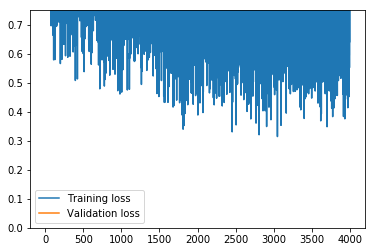

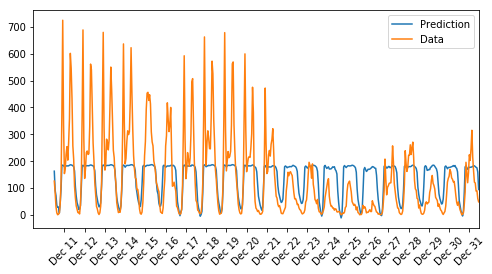

In [14]:
hyperparameter = {'learning_rate': 0.5, 'hidden_nodes': 25, 'epochs': 4000, 'batch_size': 128}

trained_model = train_validate_with_tune_tracking(train_set, valid_set, hyperparameter)
test(trained_model, torch.tensor(features_test.values).float(), torch.tensor(targets_test.values).float())

## Hyperparamter tuning with tune

### Search algorithm
Choosing hyperopt

Tune's HyperOptSearch uses hyperopt with TPE (Tree structured parzen estimators) see:

https://ray.readthedocs.io/en/latest/tune-searchalg.html#hyperopt-search-tree-structured-parzen-estimators

### Scheduler
Choosing PBT, see:

https://ray.readthedocs.io/en/latest/tune-schedulers.html#population-based-training-pbt

In [0]:
from ray.tune.suggest.hyperopt import HyperOptSearch
from hyperopt import hp, tpe
from ray.tune.schedulers import PopulationBasedTraining

def tune_it(config):
  train_validate_with_tune_tracking(train_set, valid_set, config, with_tune_tracking=True)

search_space = {'learning_rate': hp.choice('learning_rate', [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 0.7]),
                'hidden_nodes': hp.choice('hidden_nodes', [10, 25, 30]),
                'batch_size': hp.choice('batch_size', [128, 256, 10, 1])
}

hyperopt = HyperOptSearch(search_space,
                          metric="validation_loss_metric",
                          mode="min")

pbt = PopulationBasedTraining(metric='validation_loss_metric',
                              mode='min',
                              hyperparam_mutations= search_space)

tune_result = tune.run(tune_it,
                   config={'epochs': 4000},
                   local_dir='tune_logs',
                   verbose=0,
                   resources_per_trial={"cpu": 2, "gpu": 1},
                   search_alg=hyperopt,
                   num_samples = 50,
                   scheduler = pbt,
                   reuse_actors = False,
                   resume = False)

## Tune result

In [0]:
from ray.tune import Analysis

def print_config(tune_report):
  batch_size = tune_report['config/batch_size'].item()
  hidden_nodes = tune_report['config/hidden_nodes'].item()
  learning_rate = tune_report['config/learning_rate'].item()
  validation_loss_metric = tune_report['validation_loss_metric'].item()
  print("Best config: 'batch_size': {}, 'hidden_nodes': {}, 'learning_rate': {}, validation loss: {}".format(batch_size, hidden_nodes, learning_rate, validation_loss_metric))

# best config access by directory
report_0 = Analysis("/content/tune_logs/tune_it/").dataframe().sort_values('validation_loss_metric').head(1)
print_config(report_0)

# best config access by function
print("Best config: {} out of {} trials".format(tune_result.get_best_config(metric='validation_loss_metric'), len(trials)))

# best config access by dataframe - variant #1
report_1 = tune_result.dataframe().sort_values('validation_loss_metric').head(1)
print_config(report_1)

# best config access by dataframe - variant #2
report_2= tune_result.dataframe(metric="validation_loss_metric", mode="min").sort_values('validation_loss_metric').head(1)
print_config(report_2)

Best config: 'batch_size': 256, 'hidden_nodes': 10, 'learning_rate': 0.7, validation loss: 0.13463438223072796
Best config: 'batch_size': 256, 'hidden_nodes': 10, 'learning_rate': 0.7, validation loss: 0.13463438223072796
Best config: 'batch_size': 256, 'hidden_nodes': 10, 'learning_rate': 0.7, validation loss: 0.1222448822866021


In [0]:
%load_ext tensorboard
%tensorboard --logdir tune_logs/tune_it

### Test tune result
Actual tune results `batch_size: 256, hidden_nodes: 10, learning_rate: 0.7 validation loss: 0.13463438223072796
` for minimal validation loss

Progress: 100.0% Training loss: 0.062 Validation loss: 0.151 
Test loss  0.16865038871765137


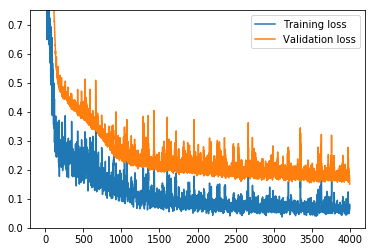

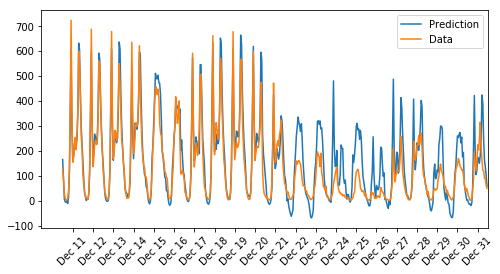

In [33]:
hyperparameter = {'learning_rate': 0.7, 'hidden_nodes': 10, 'epochs': 4000, 'batch_size': 256}

trained_model = train_validate_with_tune_tracking(train_set, valid_set, hyperparameter)
test(trained_model, torch.tensor(features_test.values).float(), torch.tensor(targets_test.values).float())

## Further steps/TODO

### Features and targets
- test with adding field *workingday*
- test with making field *holiday* categorical
- test with delete field *year*
- test with adding field *atemp*
- check standard deviation
- drop header in data
- try different bag sizes for test/validation/train sets

### Model
- add dropout
- build fcn best practice by Andrej Karpathy

### Hyperparameter tuning
- write documentation of used search algo and scheduler
- save best model
- hand different optimizer and model over to tune (in tune docs: models should be handed over as state_dict: https://ray.readthedocs.io/en/latest/using-ray-with-pytorch.html)
- log multiple metrices at once
- better understand tune result
- does my combination of hyperopt and pbt make sense?
- resume on error
- example error
```
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ray/tune/trial_runner.py", line 521, in _process_trial
    self, trial, flat_result)
  File "/usr/local/lib/python3.6/dist-packages/ray/tune/schedulers/pbt.py", line 245, in on_trial_result
    self._exploit(trial_runner.trial_executor, trial, trial_to_clone)
  File "/usr/local/lib/python3.6/dist-packages/ray/tune/schedulers/pbt.py", line 310, in _exploit
    trial_to_clone, new_config)
  File "/usr/local/lib/python3.6/dist-packages/ray/tune/schedulers/pbt.py", line 279, in _log_config_on_step
    f.write(json.dumps(policy) + "\n")
  File "/usr/lib/python3.6/json/__init__.py", line 231, in dumps
    return _default_encoder.encode(obj)
  File "/usr/lib/python3.6/json/encoder.py", line 199, in encode
    chunks = self.iterencode(o, _one_shot=True)
  File "/usr/lib/python3.6/json/encoder.py", line 257, in iterencode
    return _iterencode(o, 0)
  File "/usr/lib/python3.6/json/encoder.py", line 180, in default
    o.__class__.__name__)
TypeError: Object of type 'Apply' is not JSON serializable
```